In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
import glob
from scipy.stats import mannwhitneyu

# Result visualization

In [109]:
cwd = os.getcwd()
n = 100 # nb of random partitions
k = 5000 # nb of max top_k_edges selected
m = 10 # number of iterations on confounder-based partitions
ct_sels = ['BRCA', 'CESC', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUSC', 'PCPG', 'READ', 'STAD'] # string identifiers of cohorts
confs = ['age', 'sex', 'race', 'stage'] # string identifiers of confounders/variables
algs = ['ARACNE', 'CEMI', 'GENIE3', 'GRNBOOST2', 'WGCNA'] # string identifiers of algorithms
alpha = 0.05

### Read data from Jaccard Indices for all tools, confounders, cohorts and partition types

In [110]:
JI = pd.DataFrame(columns = ['confounder/\nvariable', 'cohort', 'method', 'partition type', 'partID', 'k', 'mean JI'])
for alg_sel in algs:
    for conf_sel in confs:
        for ct_sel in ct_sels:
            path = os.path.join(cwd, alg_sel, 'JI_'+str(alg_sel)+'_'+str(ct_sel))
            for i in range(n):
                filename = 'cb'+'_'+str(i)+'_'+alg_sel+'_'+conf_sel+'_'+ct_sel+'_jaccInd.csv'
                try:
                    df_conf = pd.read_csv(os.path.join(path, filename), sep=',', header=0)
                    df_conf['partID'] = i
                    df_conf['partition type'] = 'confounder-based'
                    df_conf['method'] = alg_sel
                    df_conf['cohort'] = ct_sel
                    df_conf['confounder/\nvariable'] = conf_sel
                except:
                    continue
                filename = 'rnd'+'_'+str(i)+'_'+alg_sel+'_'+conf_sel+'_'+ct_sel+'_jaccInd.csv'
                try:
                    df_rnd = pd.read_csv(os.path.join(path, filename), sep=',', header=0)
                    df_rnd['partID'] = i
                    df_rnd['partition type'] = 'random'
                    df_rnd['method'] = alg_sel
                    df_rnd['cohort'] = ct_sel
                    df_rnd['confounder/\nvariable'] = conf_sel
                except:
                    continue
                JI = pd.concat([JI, df_conf, df_rnd])
print(JI.head())

  confounder/\nvariable cohort  method    partition type partID    k  \
0                   age   BRCA  ARACNE  confounder-based      0   10   
1                   age   BRCA  ARACNE  confounder-based      0   60   
2                   age   BRCA  ARACNE  confounder-based      0  110   
3                   age   BRCA  ARACNE  confounder-based      0  160   
4                   age   BRCA  ARACNE  confounder-based      0  210   

    mean JI  size intersection  size union      state  
0  0.428571                6.0        14.0  filled01_  
1  0.395349               34.0        86.0  filled01_  
2  0.401274               63.0       157.0  filled01_  
3  0.367521               86.0       234.0  filled01_  
4  0.368078              113.0       307.0  filled01_  


In [111]:
JI_all = JI.copy()
JI_all['confounder/\nvariable'] = JI_all['confounder/\nvariable'].replace(['race'], 'ethnicity')
confs = ['age', 'ethnicity', 'sex', 'stage']
JI_all = JI_all[JI_all['k']%100 == 10]

### 1) Plot mean JI over k per cohort and per confounder

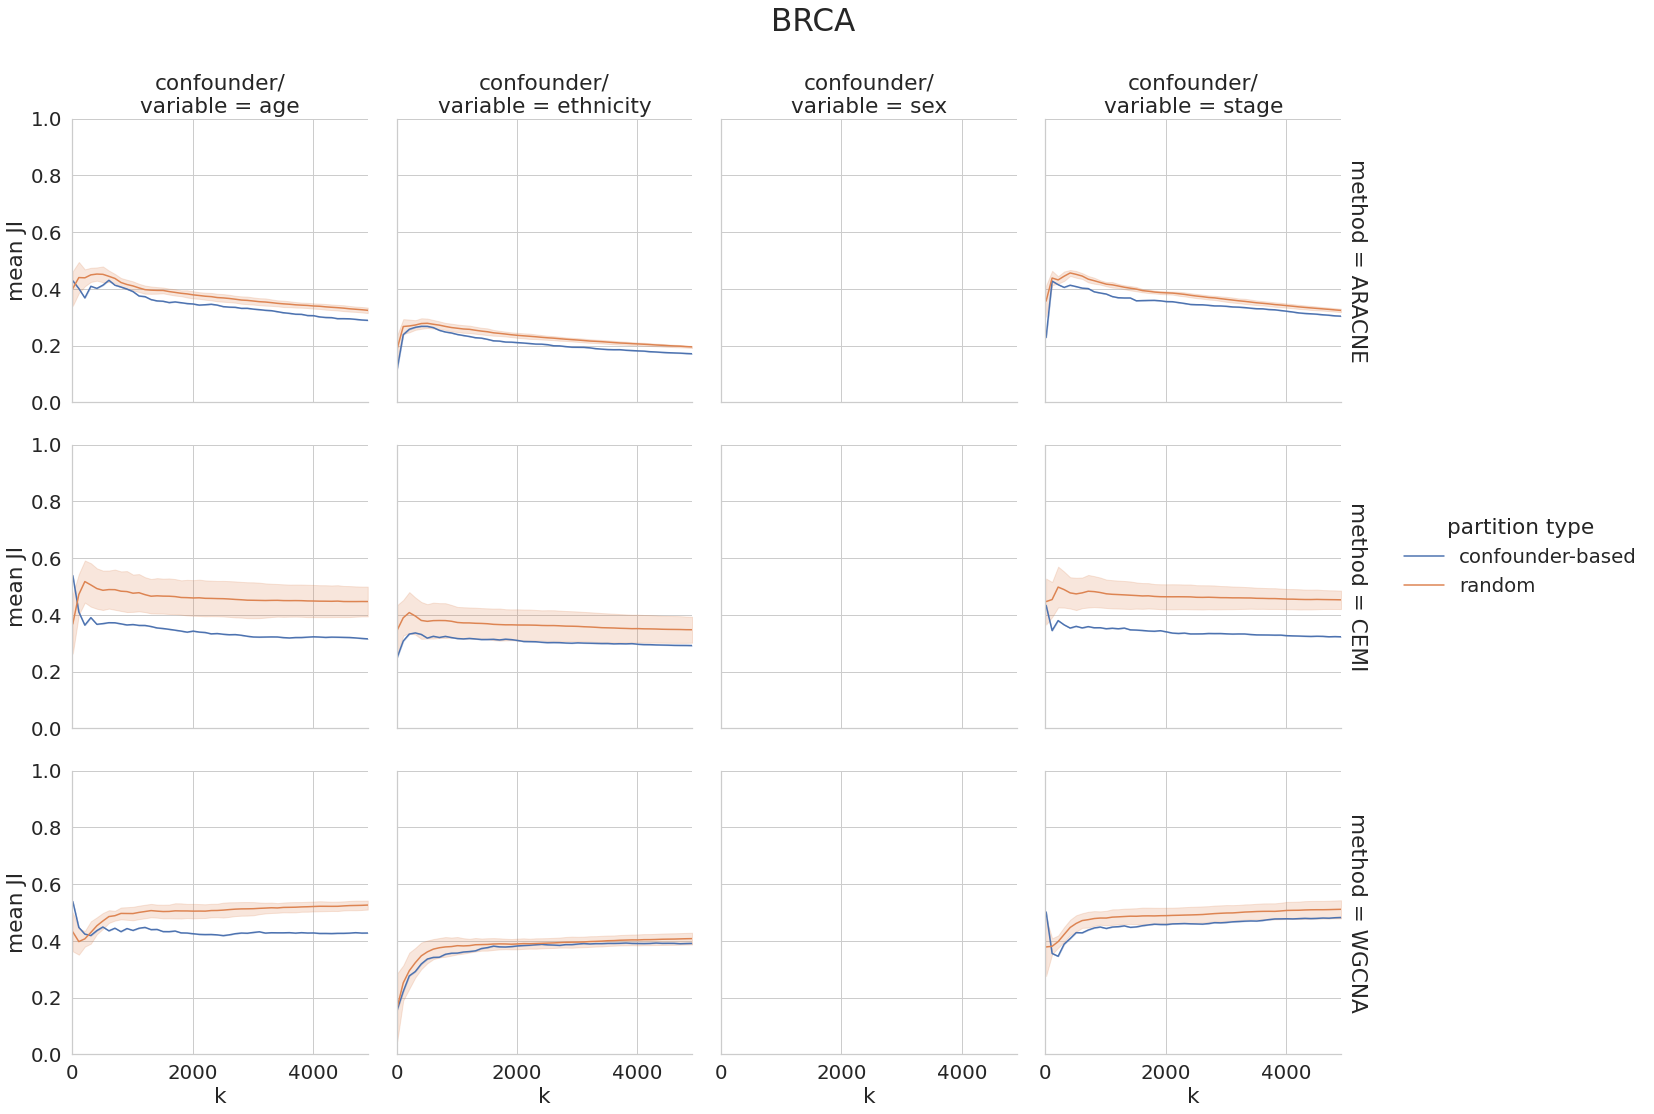

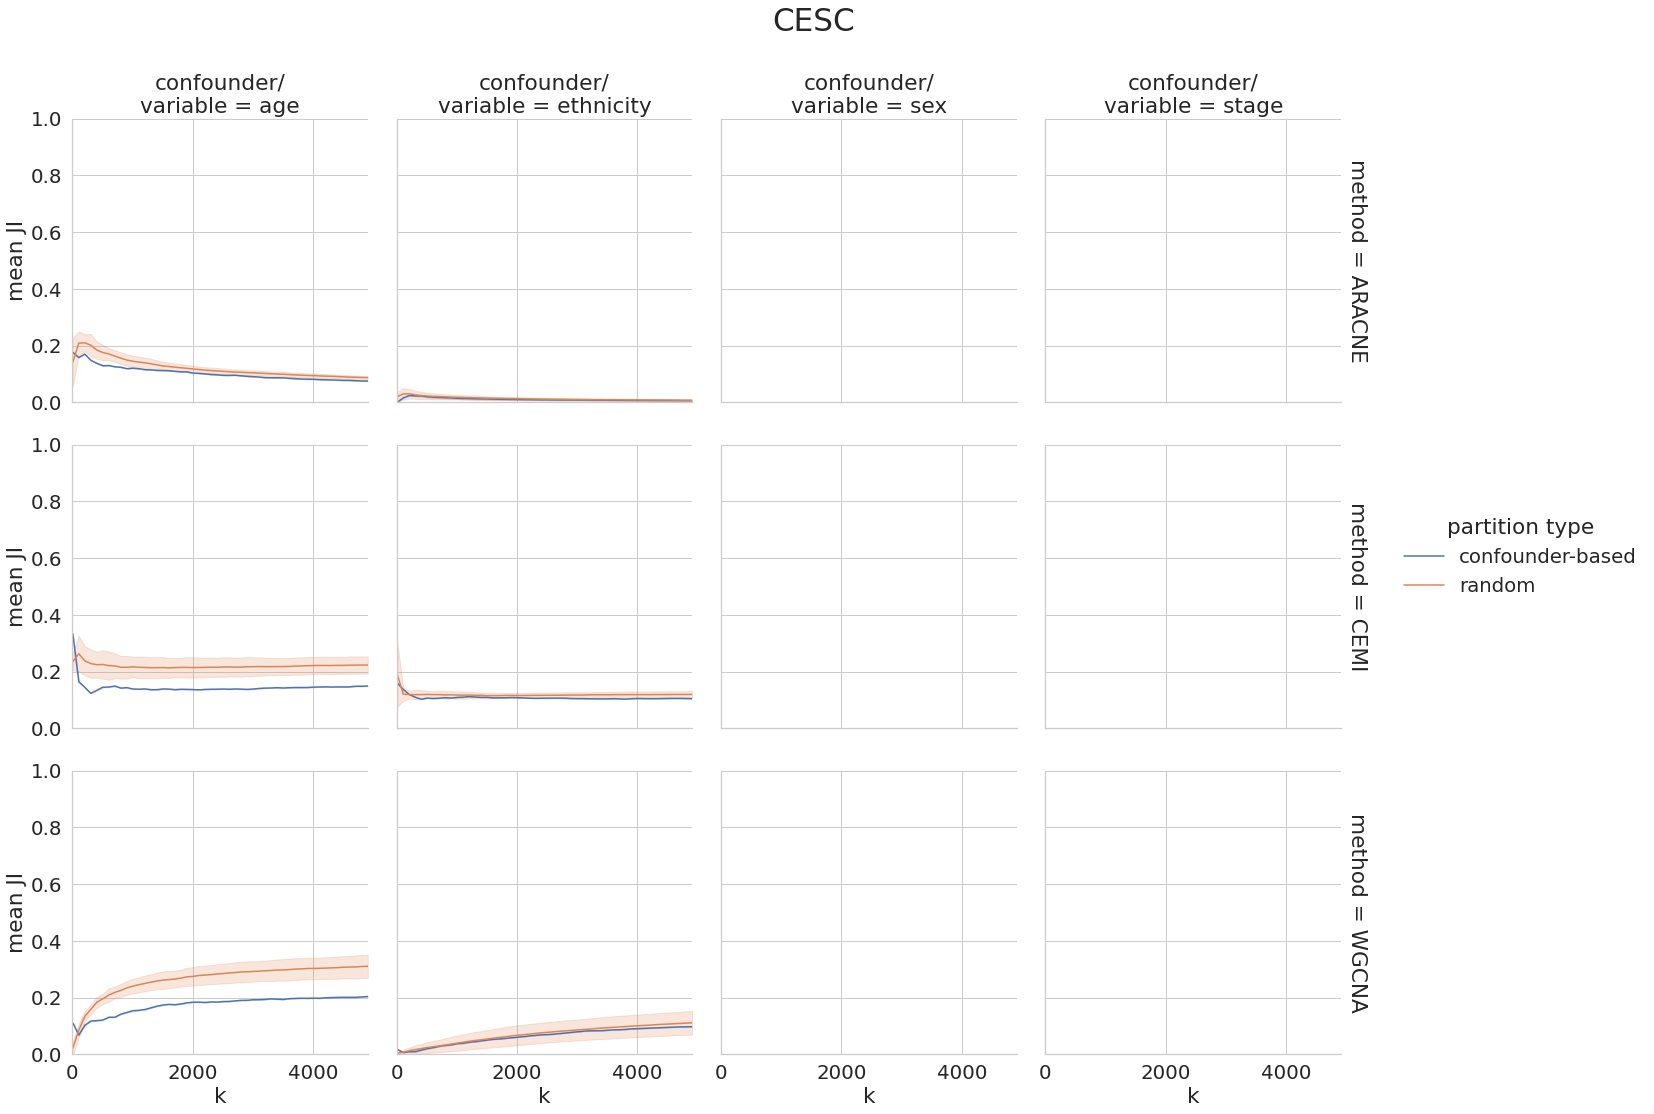

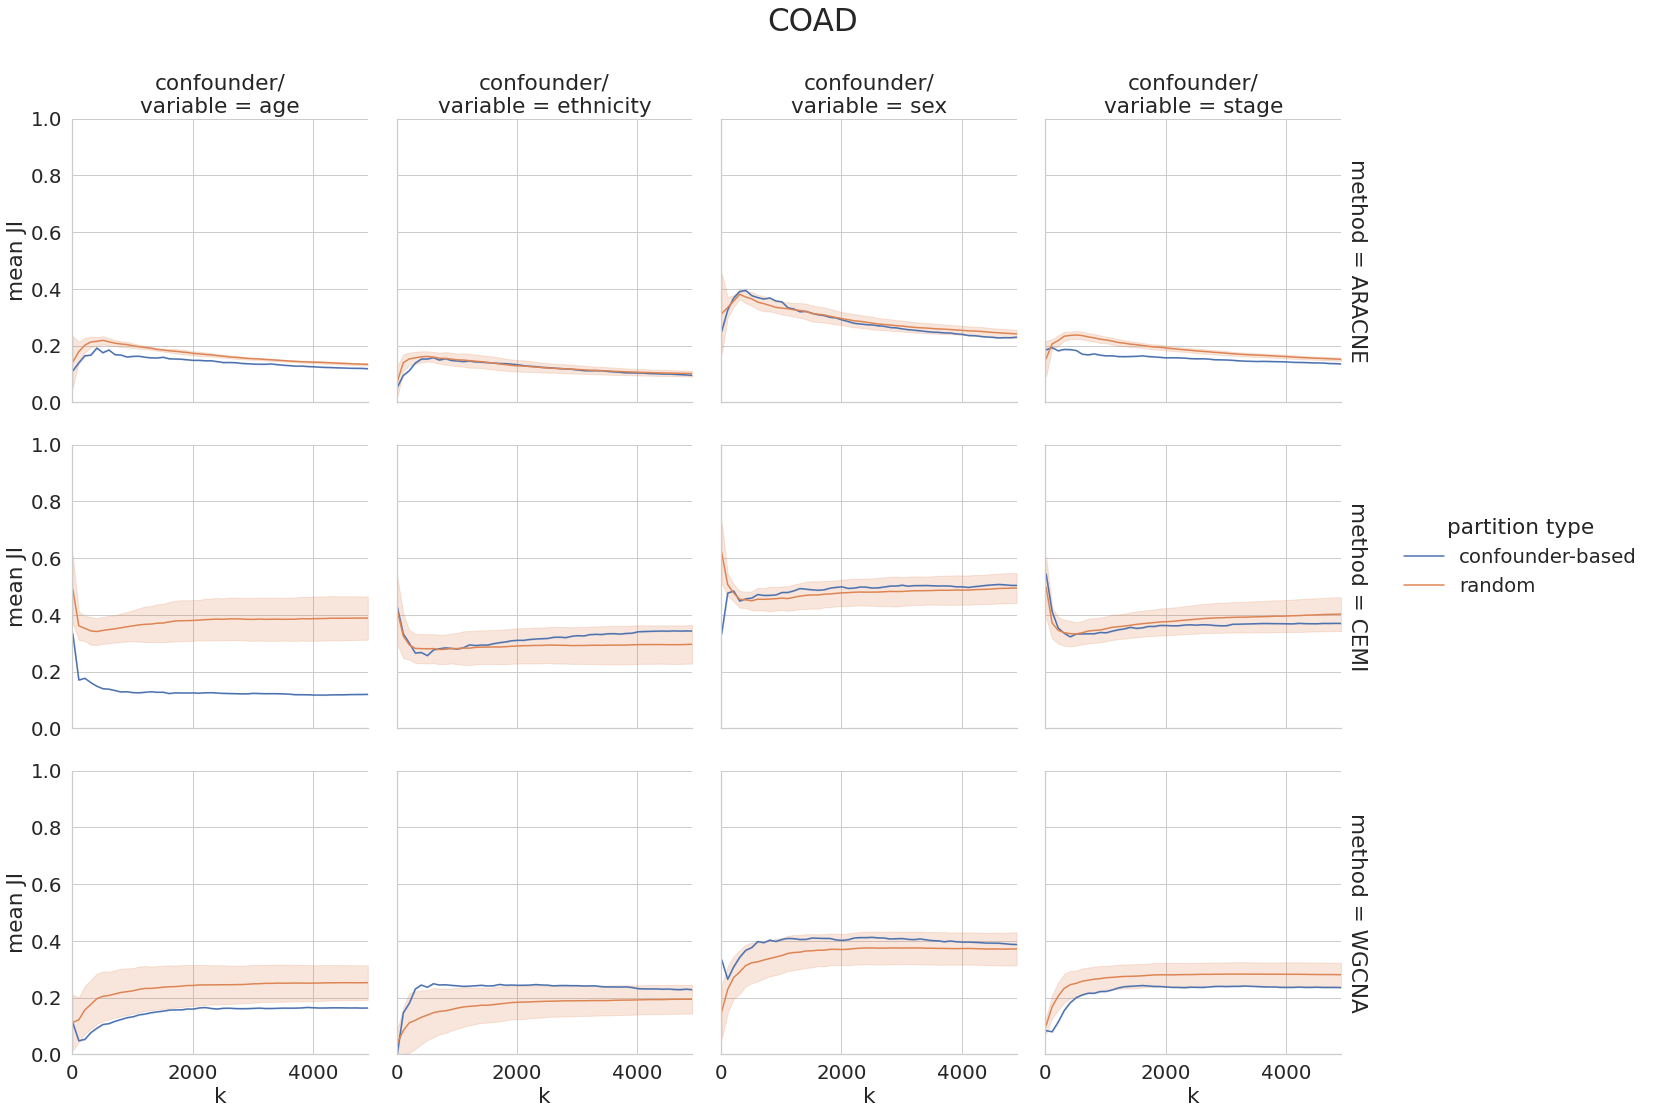

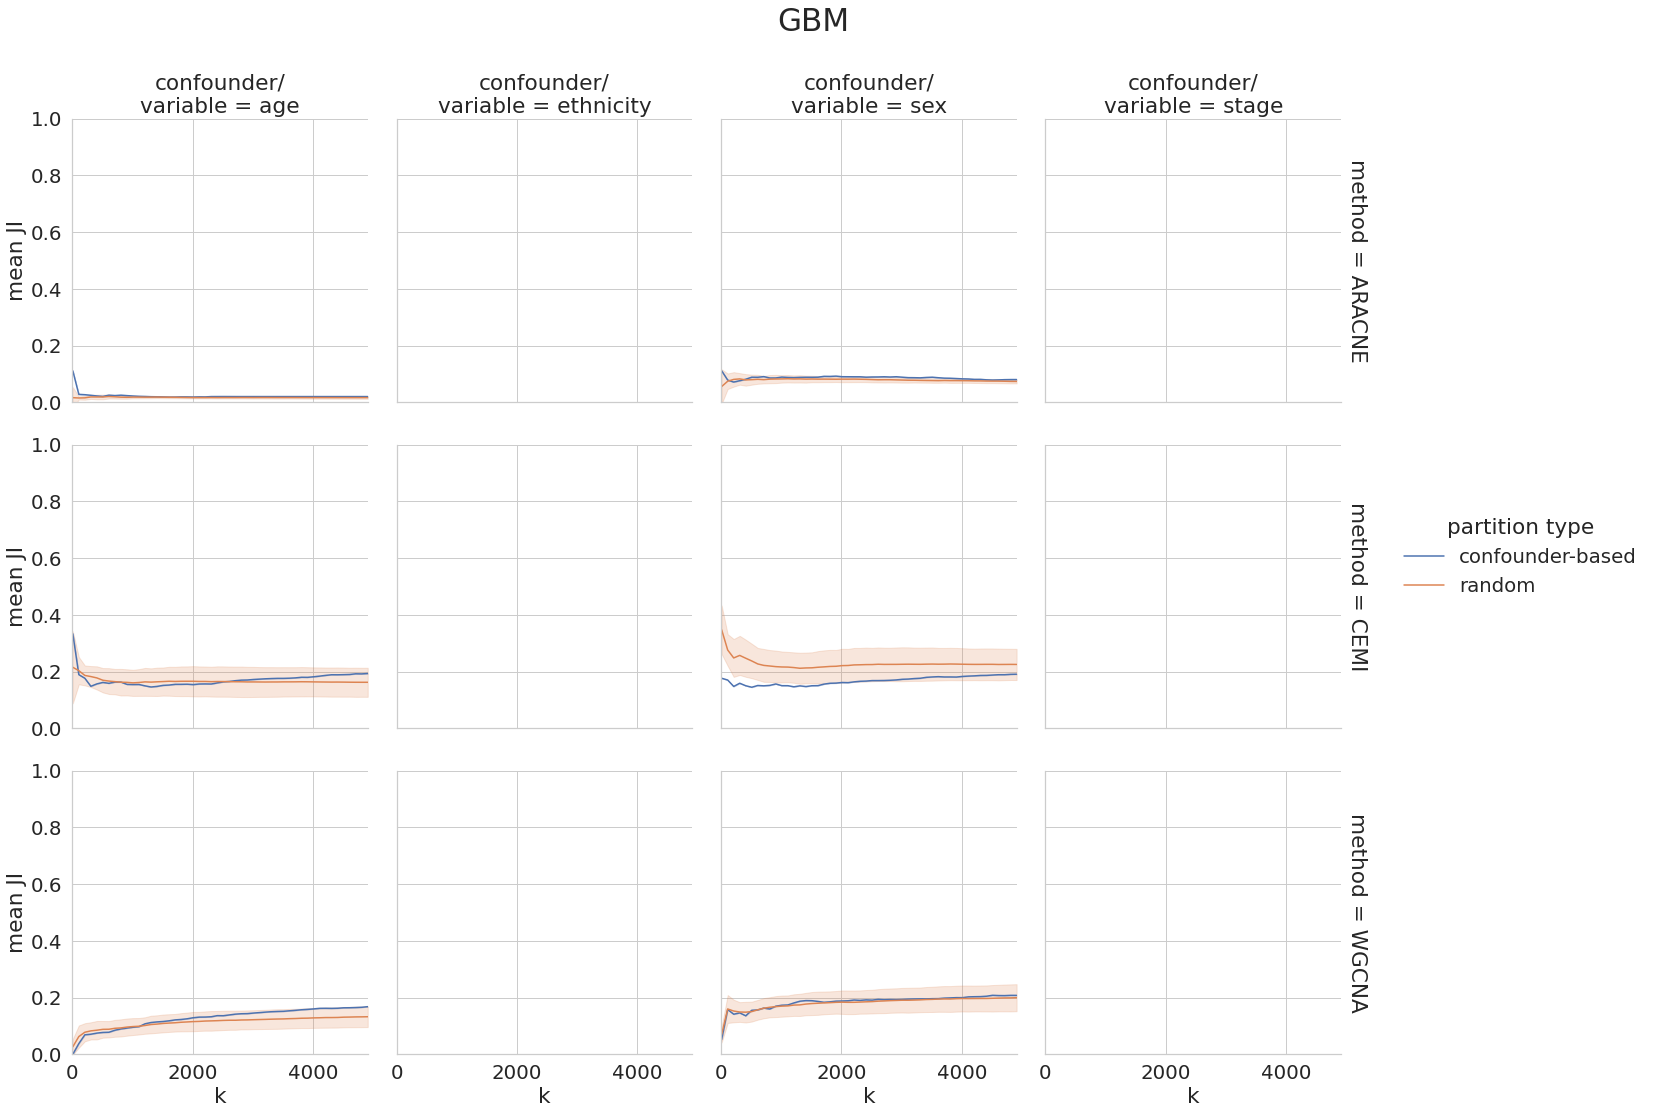

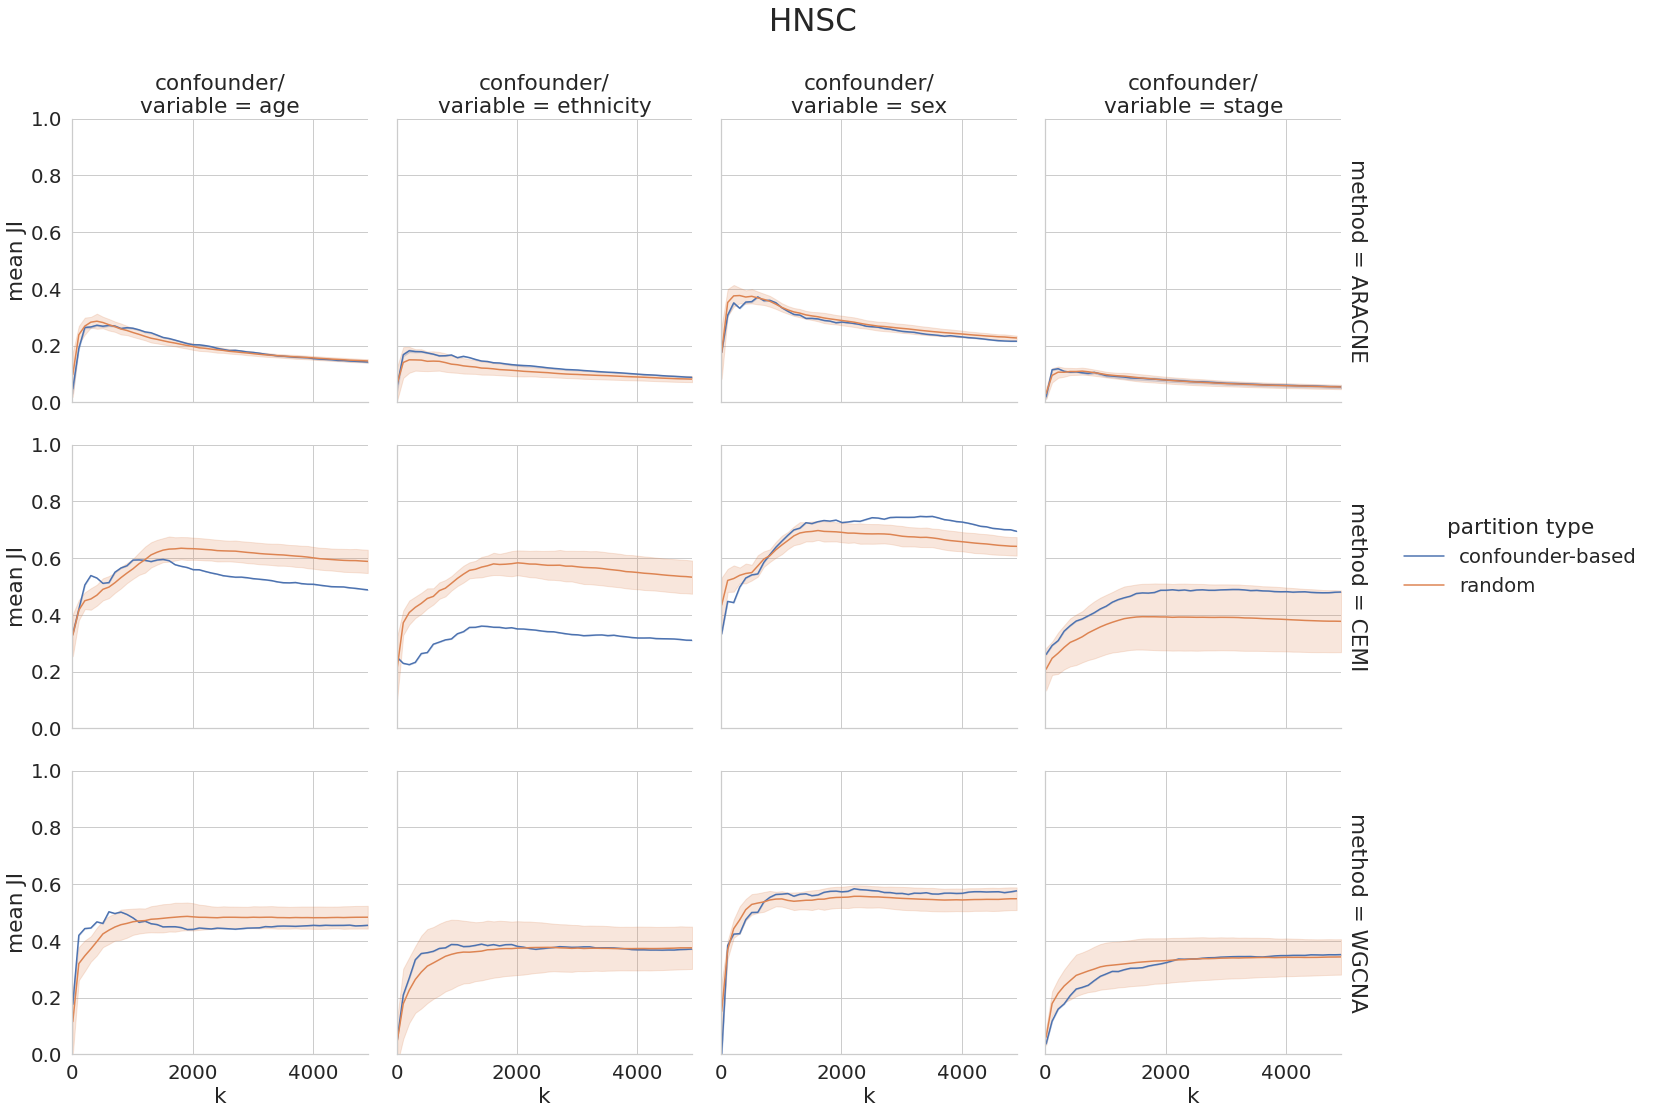

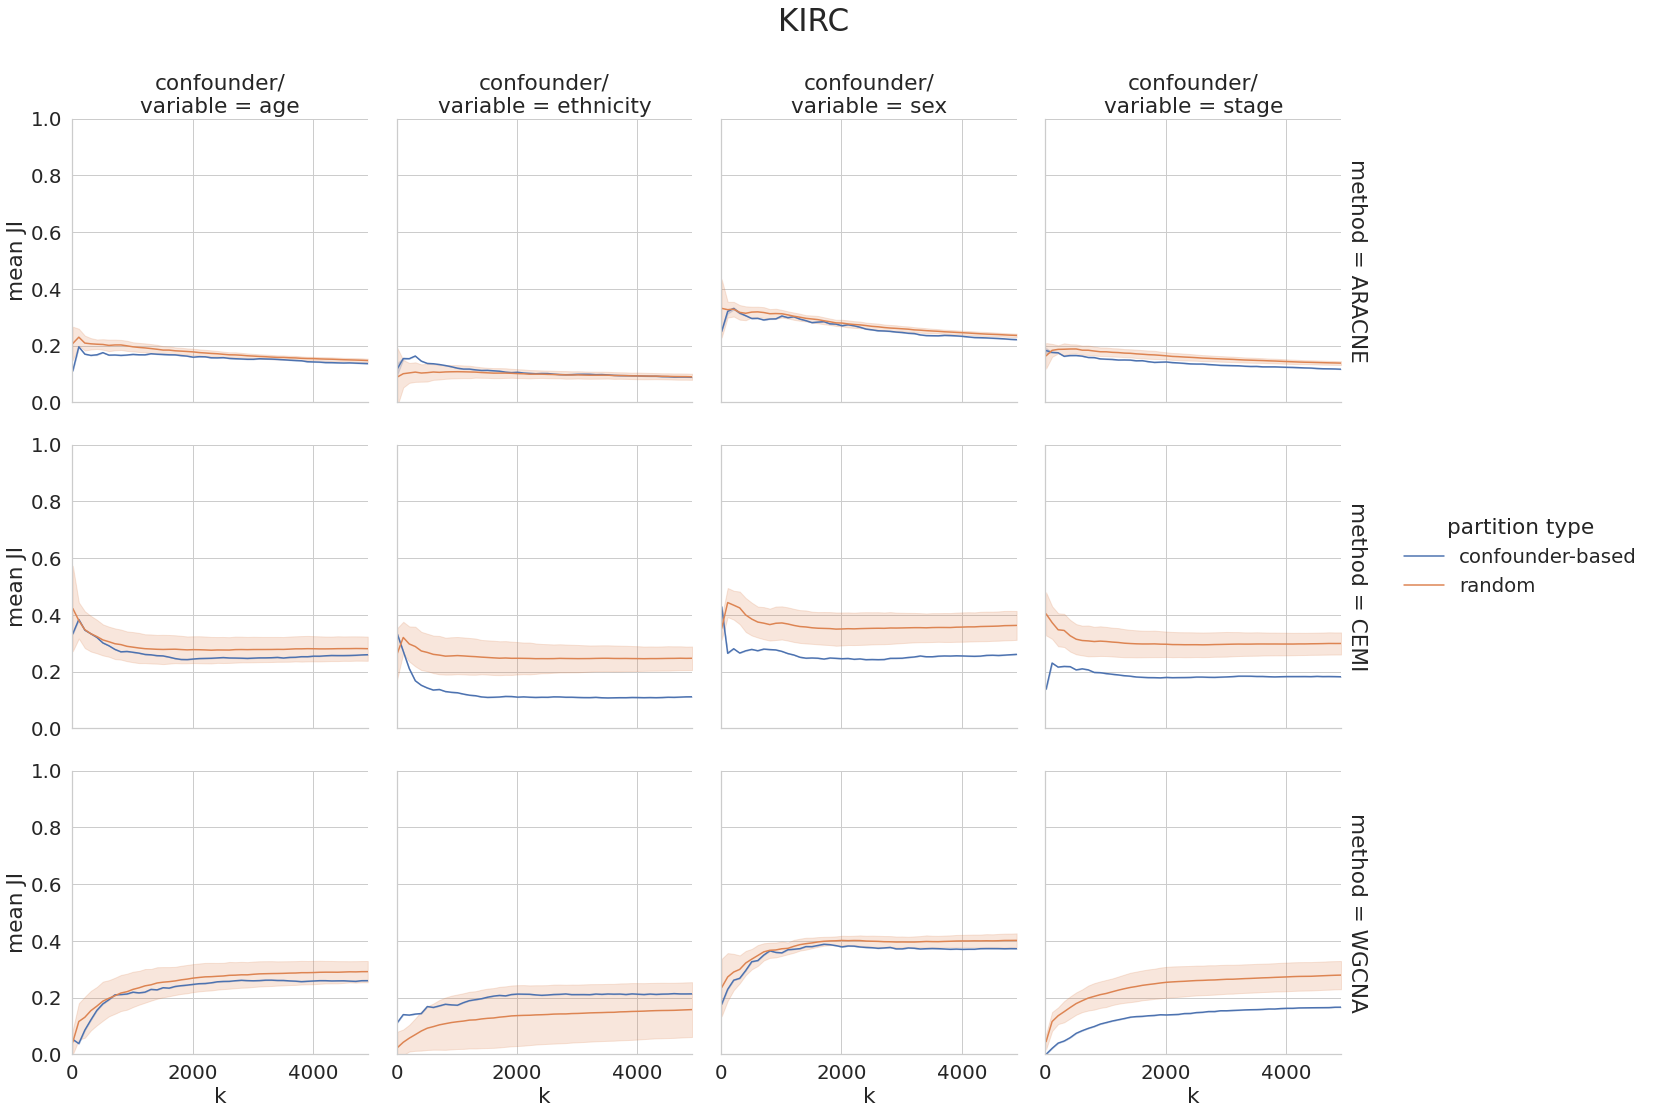

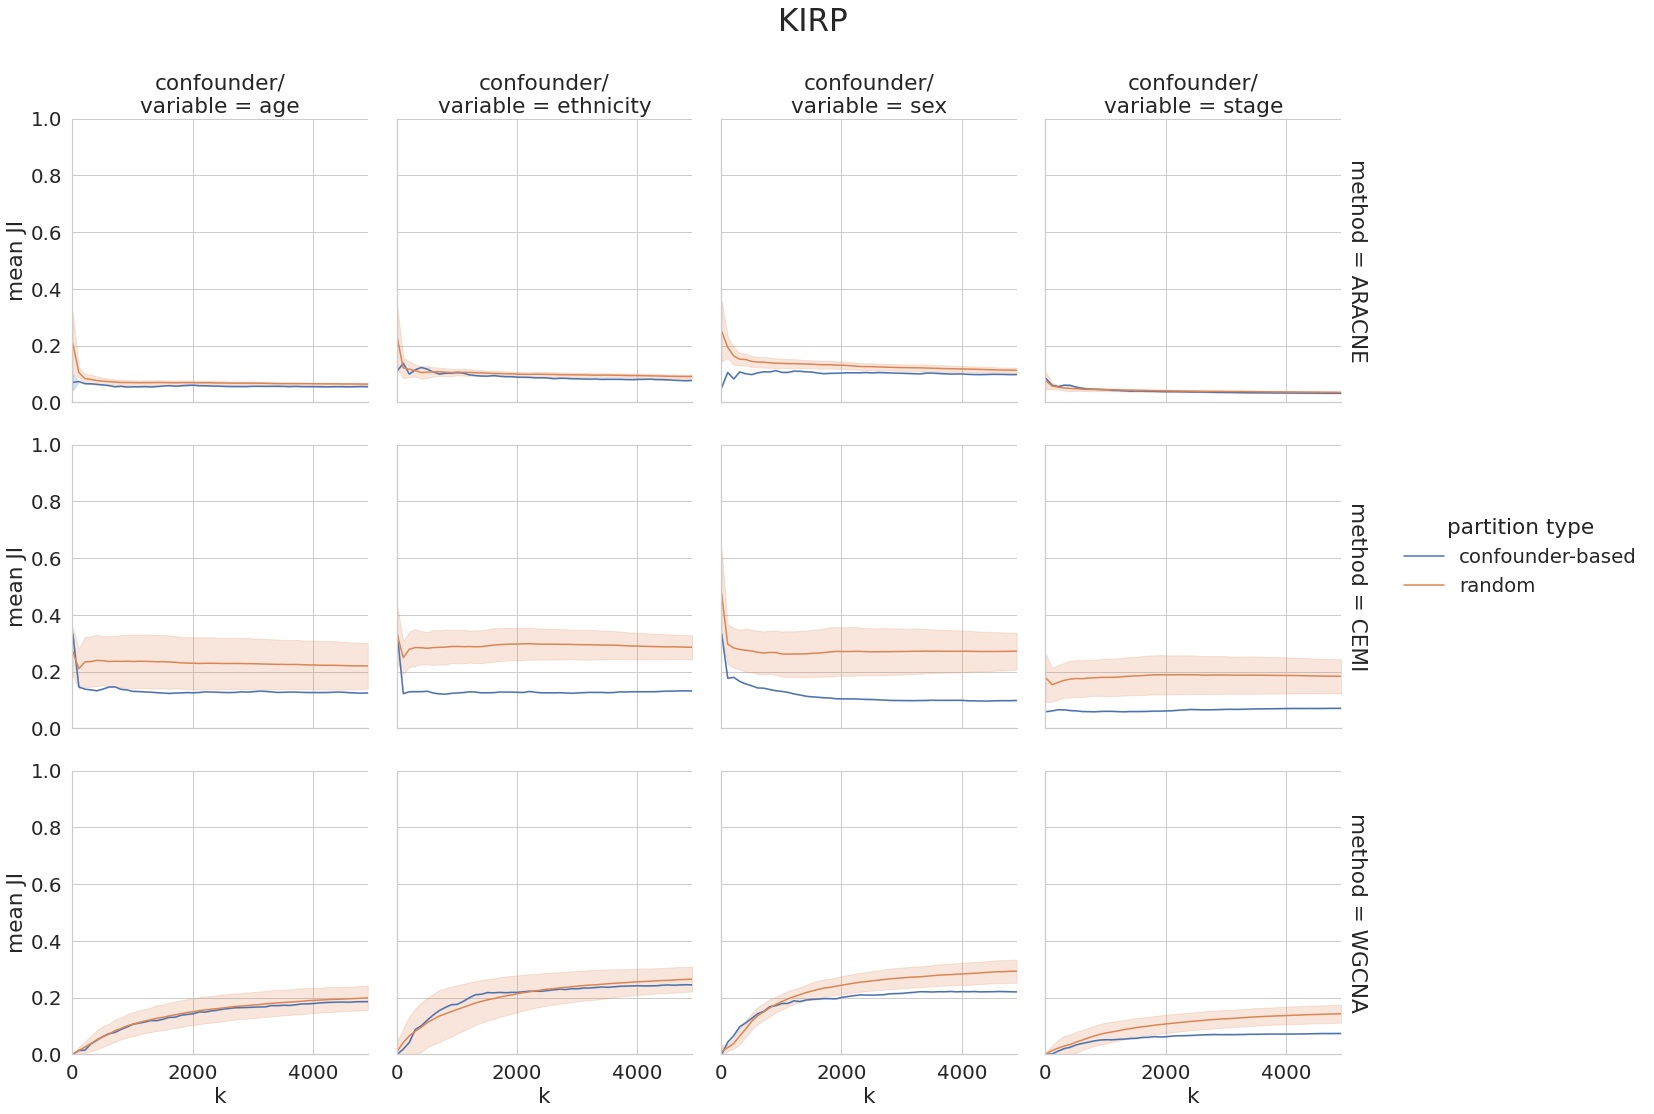

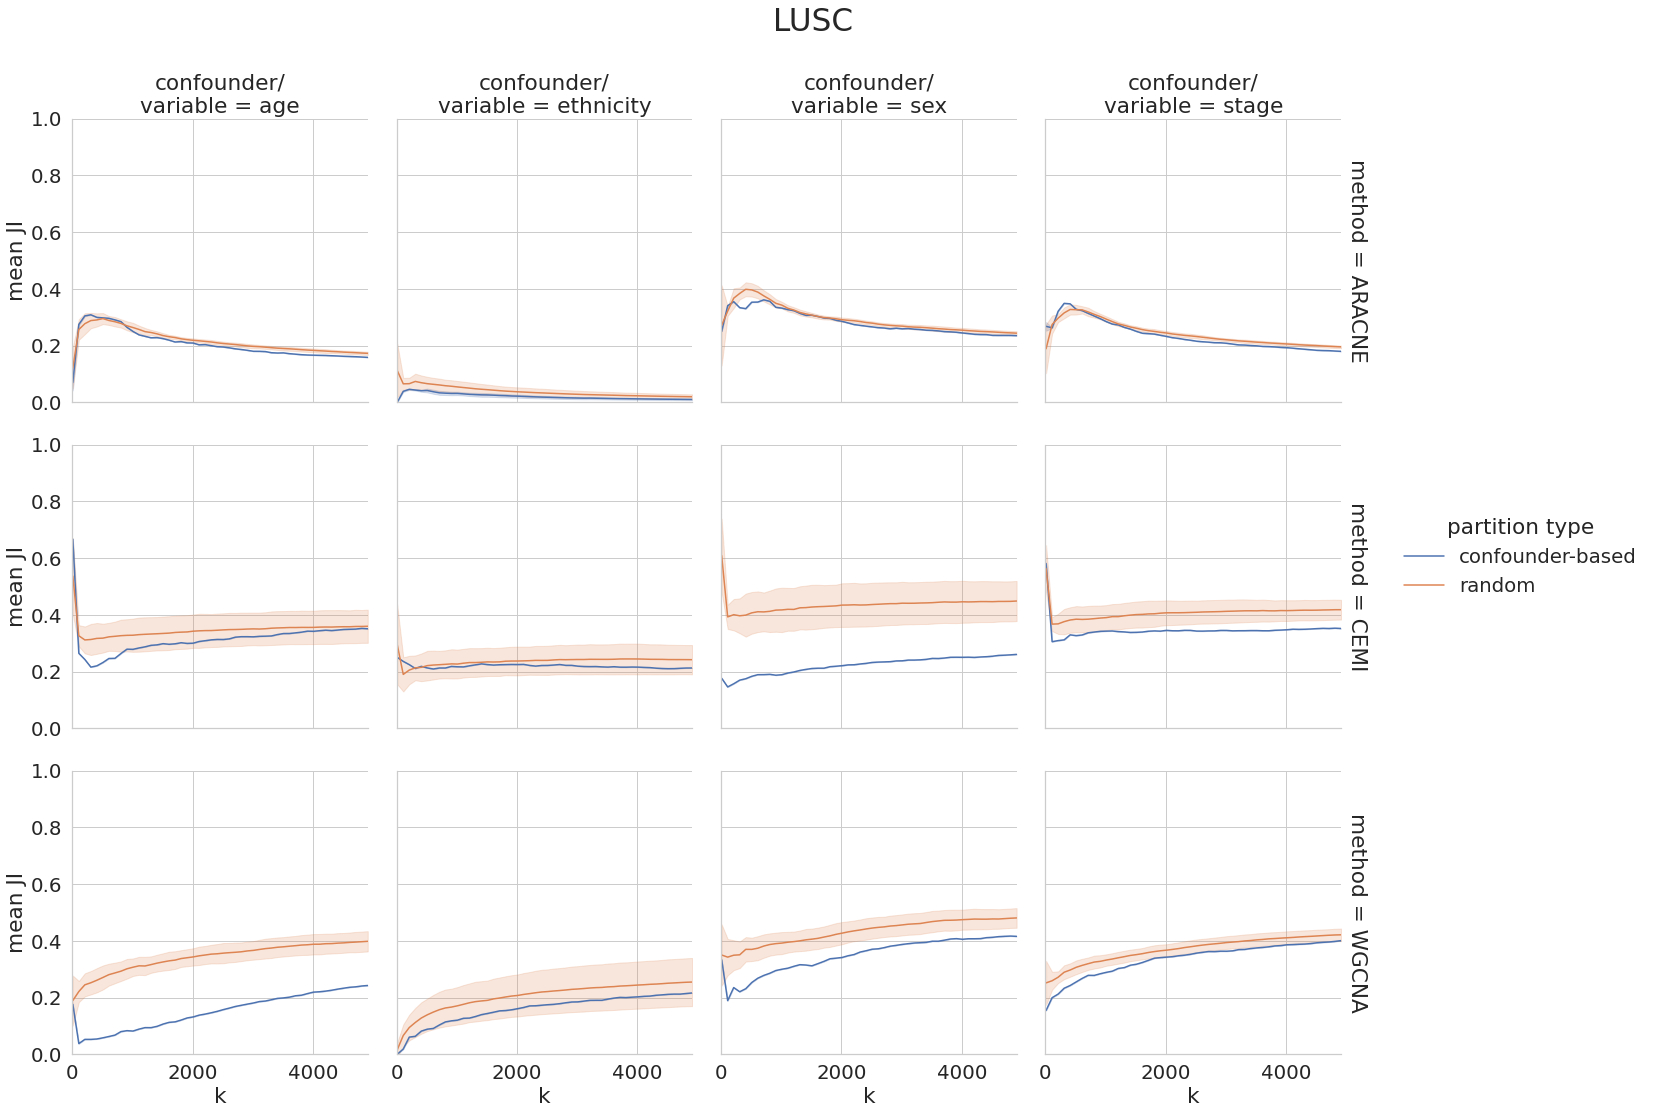

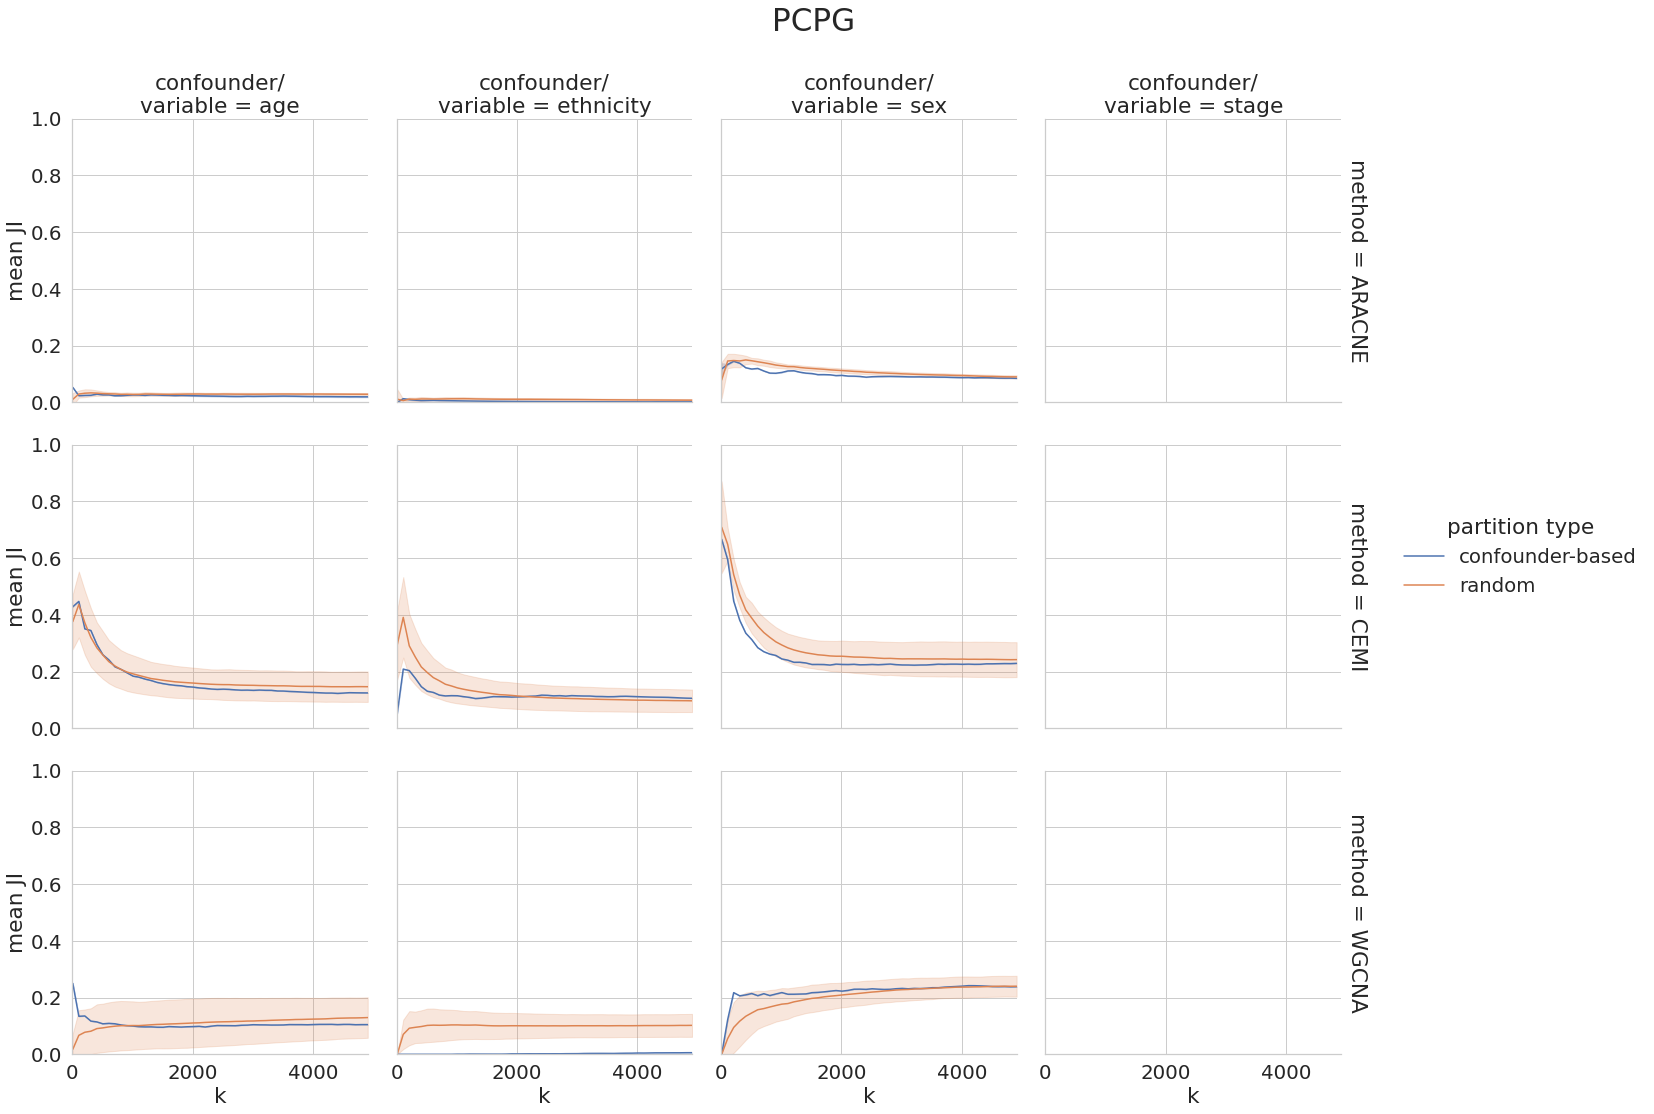

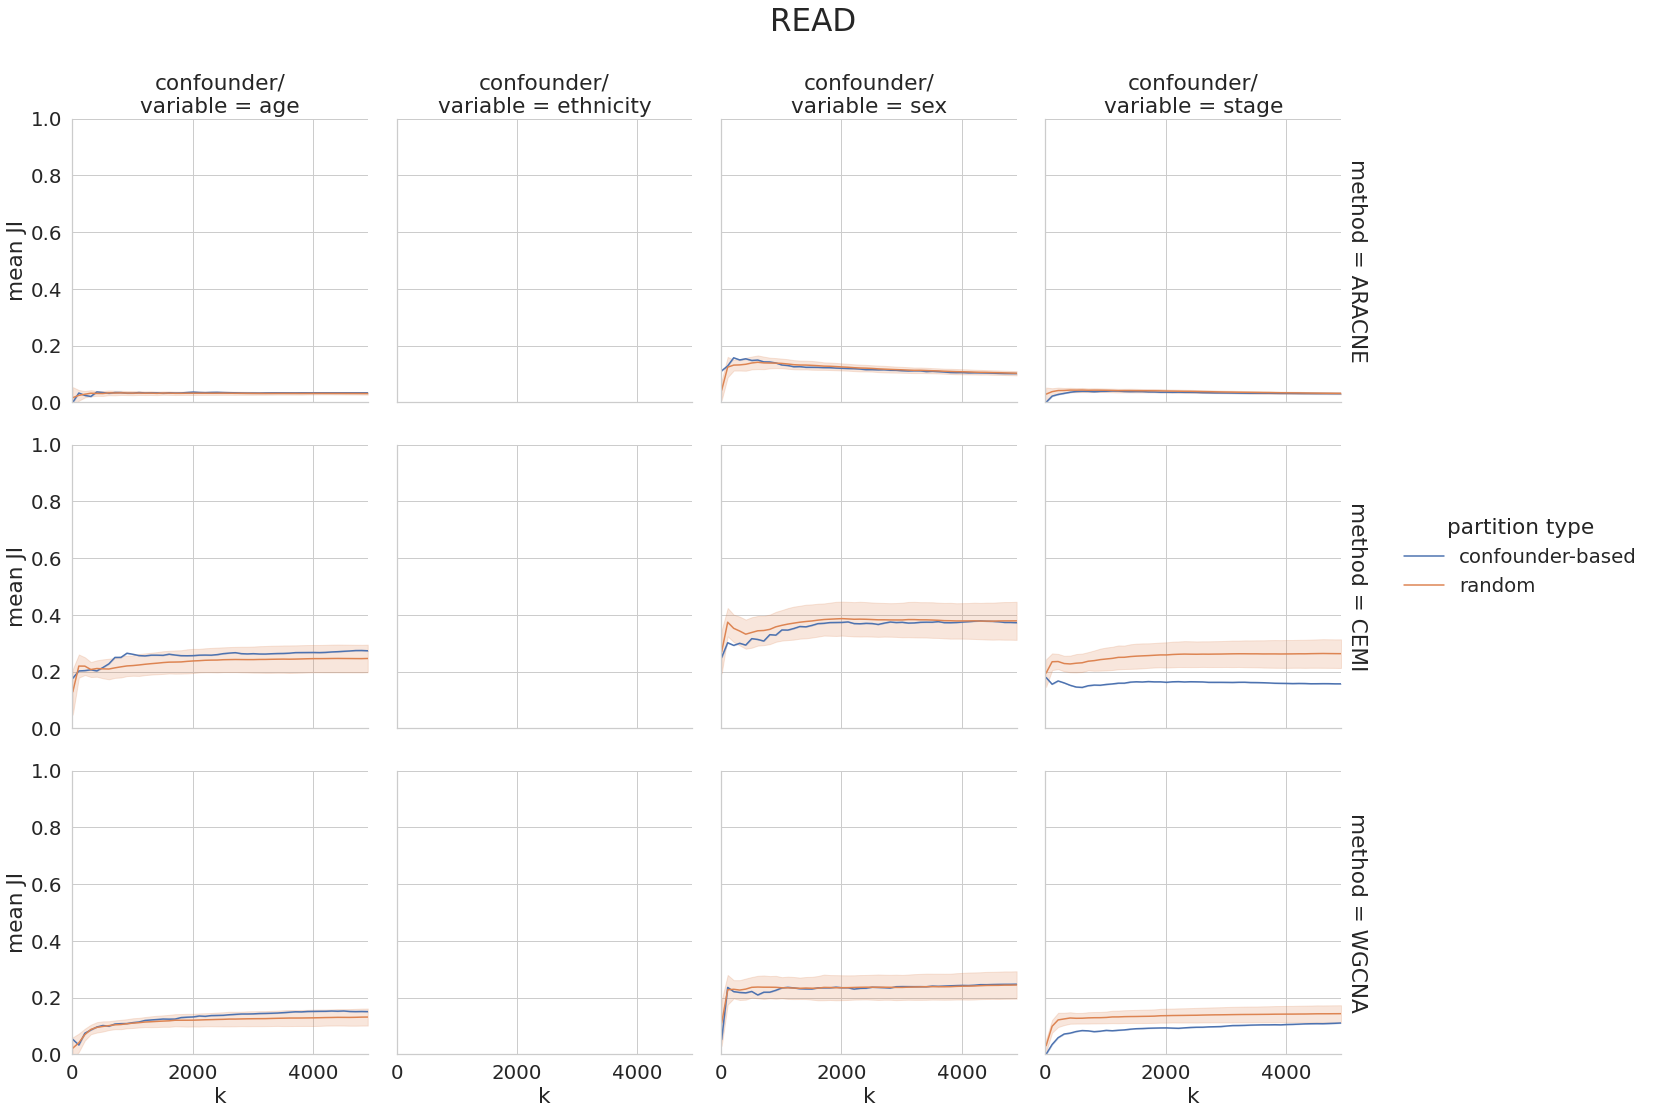

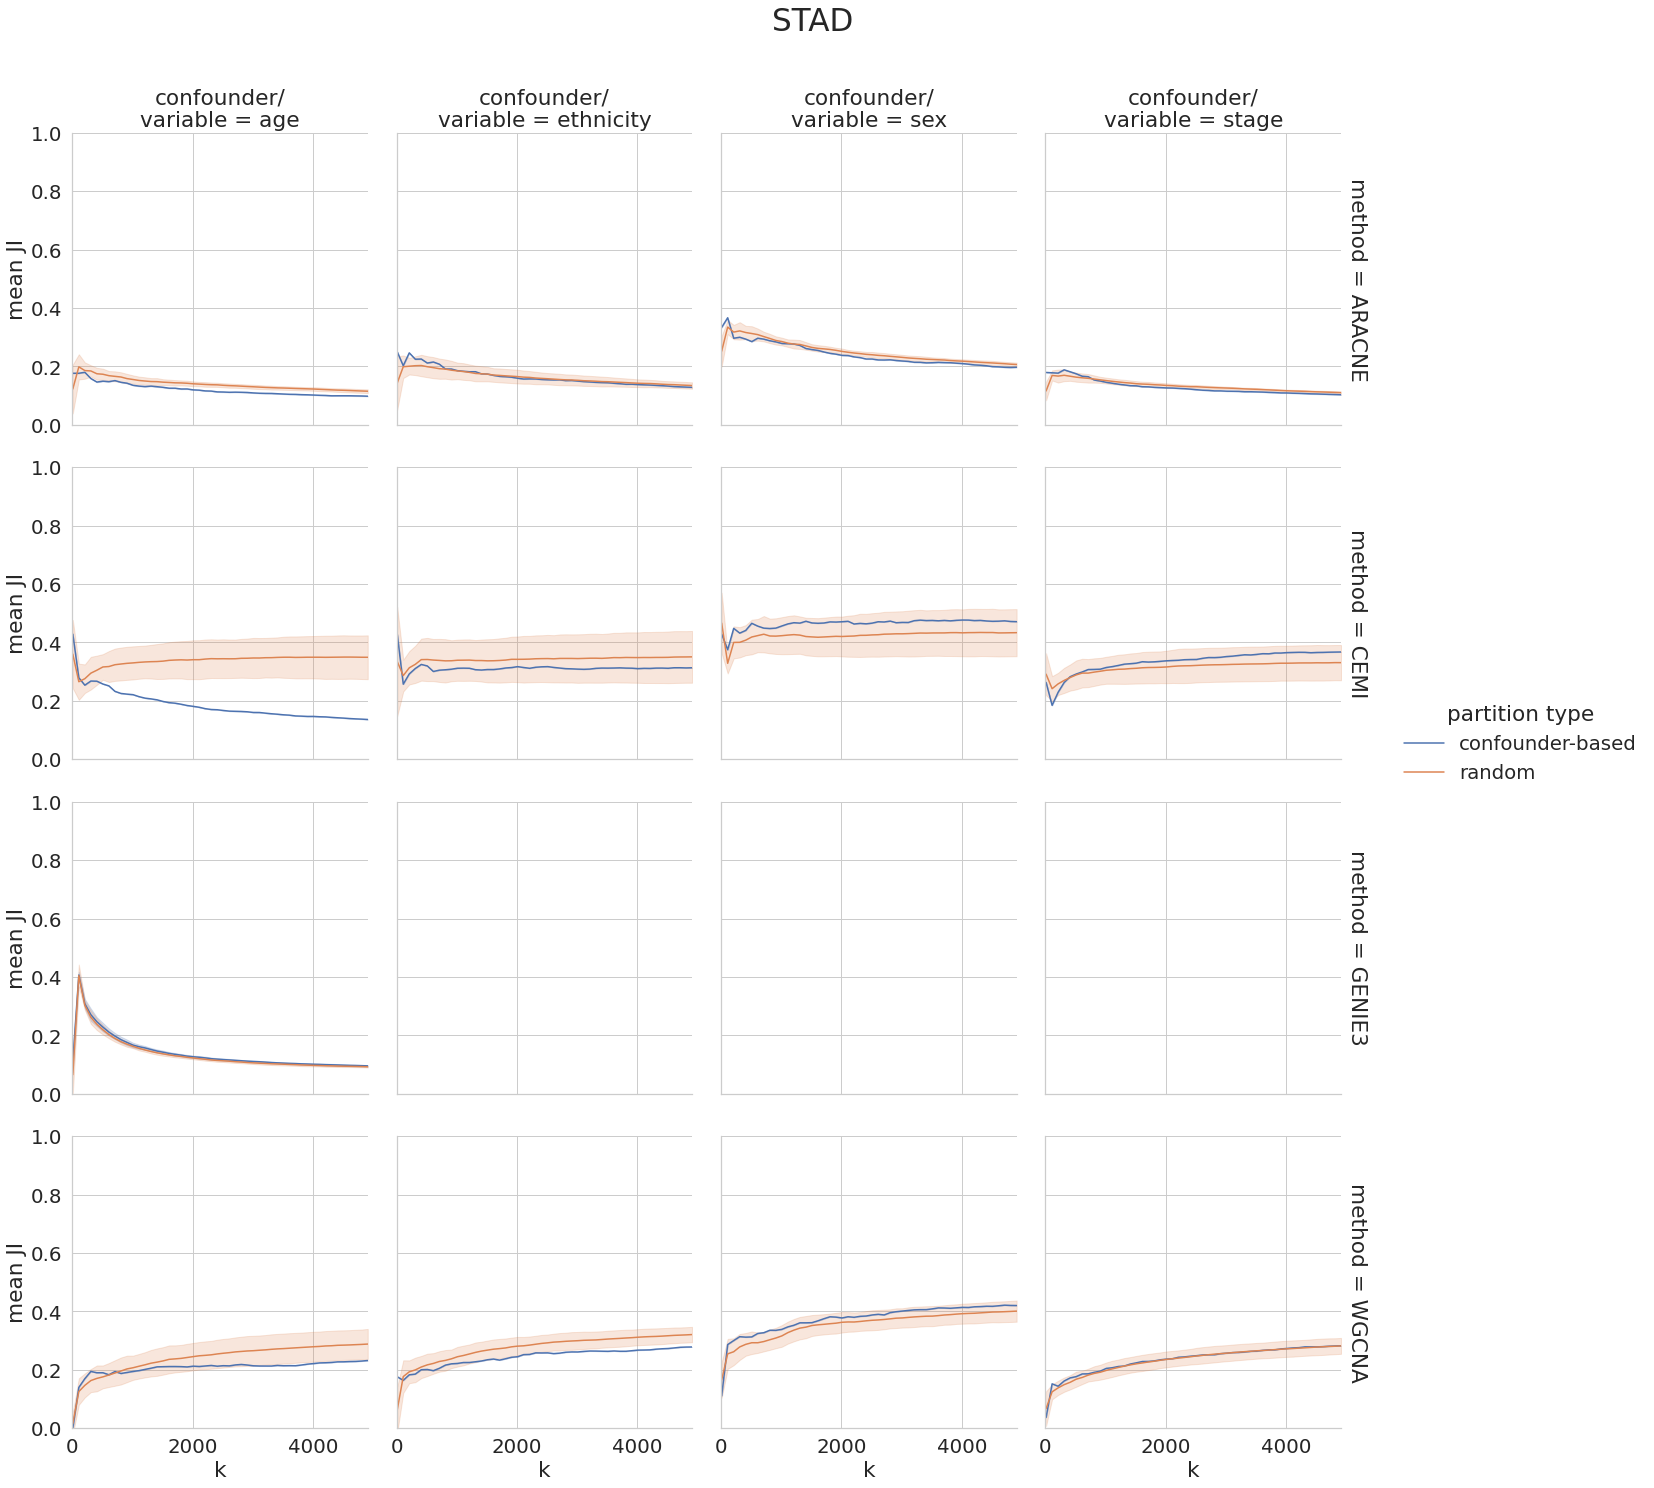

In [112]:
sns.set(font_scale=1.8)
sns.set_style('whitegrid')
for ct_sel in ct_sels:
    JI = JI_all[JI_all['cohort'] == ct_sel]
    frms = len(set(JI['confounder/\nvariable']))
    g = sns.FacetGrid(JI, row='method', col='confounder/\nvariable', hue='partition type', 
                      margin_titles=True, ylim=(0,1), xlim=(0,max(JI['k'].values)), legend_out=True, height=5,
                    col_order=['age', 'ethnicity', 'sex', 'stage'])
    ax = g.axes[0,0]
    g.map(sns.lineplot, "k", "mean JI",errorbar='sd').add_legend()
    g.fig.suptitle(str(ct_sel), y=1.04, fontsize='x-large')
    

### test conf < rnd with one-sided Mann-Whitney-U  test for each k

In [113]:
mwus = pd.DataFrame(columns=['method', 'cohort', 'confounder/\nvariable', 'k', 'mwu.pvalue'])
for alg_sel in algs:
    JI = JI_all[JI_all['method'] == alg_sel]
    for cohort in ct_sels:
        coh = JI[JI['cohort'] == cohort]
        for conf_sel in confs:
            conf = coh[coh['confounder/\nvariable'] == conf_sel]
            if len(conf) == 0:
                continue
            c = conf[conf['partition type']=='confounder-based']
            r = conf[conf['partition type']=='random']
            for k in sorted(list(set(c['k']))):
                c_k = c[c['k'] == k]
                r_k = r[r['k'] == k]
                assert len(c_k) == len(r_k)
                mwu = mannwhitneyu(c_k['mean JI'],r_k['mean JI'], alternative='less')
                df = pd.DataFrame([[alg_sel, cohort, conf_sel, k, mwu.pvalue]], columns=['method', 'cohort', 'confounder/\nvariable', 'k', 'mwu.pvalue'])
                mwus = pd.concat([mwus, df])
mwus.reset_index(inplace=True)
mwus = mwus.drop('index', axis=1)
count = mwus.groupby(['method', 'cohort', 'confounder/\nvariable']).count()
sign = mwus[mwus['mwu.pvalue'] < alpha]
sign = sign.groupby(['method', 'cohort', 'confounder/\nvariable']).count()
sign['frac'] = sign['mwu.pvalue']/count['mwu.pvalue']

In [114]:
sign = sign.drop('mwu.pvalue', axis=1).drop('k', axis=1)

In [115]:
sign

frac
method cohort confounder/\nvariable      
ARACNE BRCA   age                    0.96
              ethnicity              0.94
              stage                  1.00
       CESC   age                    0.98
              ethnicity              0.02
...                                   ...
WGCNA  READ   sex                    0.02
              stage                  1.00
       STAD   age                    0.62
              ethnicity              0.74
              sex                    0.02

[92 rows x 1 columns]

In [116]:
import datetime
stamp = datetime.datetime.now().strftime("%d-%m-%Y_%H:%M:%S")
#sign.to_csv(f'mwu_pvalues_{str(stamp)}.csv')

<ipython-input-126-791345401f46>:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.swarmplot(_mwus[_mwus['cohort'] == ct_sel], x='confounder/\nvariable', y='frac', hue='method',


<Figure size 432x288 with 0 Axes>

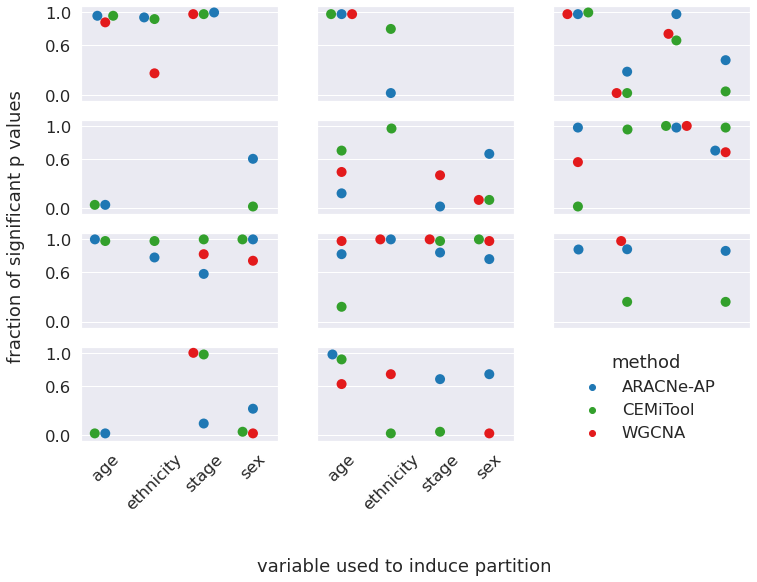

In [126]:
### UNDER CONSTRUCTION
import math
plt.tight_layout()
sns.set(font_scale=1.5)
sns.set_style("darkgrid")
_mwus = pd.DataFrame(sign).reset_index()
_mwus = _mwus.replace('ARACNE', 'ARACNe-AP').replace('CEMI', 'CEMiTool').replace('GRNBOOST2', 'GRNBoost2')
fig, axs = plt.subplots(4, 3, figsize=(12, 8), sharey=True, sharex=True)
i = j = 0
for ct_sel in ct_sels:
    axs[i,j].set_ylim([-0.075, 1.075])
    for tick in axs[i,j].get_xticklabels():
        tick.set_rotation(45)
    g = sns.swarmplot(_mwus[_mwus['cohort'] == ct_sel], x='confounder/\nvariable', y='frac', hue='method', 
                    ax=axs[i,j], s=10, palette=sns.color_palette('Paired')[1:7:2], legend=(i==j==0))
    g.set(xlabel=None, ylabel=None)
    j = (j + 1) % 3
    i = i + 1 if j == 0 else i
fig.text(0.5, -0.1,'variable used to induce partition', ha='center')
fig.text(0.04, 0.5, 'fraction of significant p values', va='center', rotation='vertical')
plt.yticks([0.0, 0.6, 1.0])
sns.move_legend(axs[0,0], "lower right", frameon=False, bbox_to_anchor=(3.3, -3.75))
fig.delaxes(axs[i,j])